# Read the HTTP Stream and Forward It into Kafka

## Producer script

In [7]:

import requests
from confluent_kafka import Producer
import pandas as pd
import requests
import json
    

# Kafka configuration
kafka_config = {
    'bootstrap.servers': 'localhost:19092,localhost:19093',
    'retries': 2,
    'retry.backoff.ms': 1000,
    'client.id': 'stream-to-kafka-producer'
}

# Kafka producer
producer = Producer(kafka_config)
producer.poll(1.0)
# Define the Kafka topic
topic = 'test-topic'

# Function to handle delivery reports 
def delivery_report(err, msg):
    if err is not None:
        print(f"Message delivery failed: {err}")
    else:
        print(f"Message delivered to {msg.topic()} [{msg.partition()}] @ offset {msg.offset()}")


def partition_func(seq, num_partitions):
    # round-robin modulo
    return seq % num_partitions

# Function to stream data from URL to Kafka
def stream_data_to_kafka(url):
    num_partitions=3
    try:
        # Open a streaming HTTP connection and write NDJSON lines to a file.
        with requests.get(url, stream=True) as r, open("data.ndjson", "wb") as f:

            for i, line in enumerate(r.iter_lines()):

                if not line:
                    continue
                    
                line_str = line.decode("utf-8")
                record = json.loads(line_str)
                seq = record["seq"]
                partition = partition_func(seq, num_partitions)
                    
   
                # Write raw NDJSON line to file
                f.write(line + b"\n")
                producer.produce(topic, value=line,  key=str(seq), partition=partition, callback=delivery_report)
                producer.poll(0)

                # Example: stop after 50 events
                if i >= 50:
                    producer.flush()
                    break

    except Exception as e:
        print(f"Error occurred: {e}")

# URL from which we want to stream data
url = "http://10.0.0.2:30080/stream?rate=1.0&n_sensors=1&pattern=random&noise=0.1"  # Replace with your URL

# Start streaming data from the URL to Kafka
stream_data_to_kafka(url)


Message delivered to test-topic [0] @ offset 28
Message delivered to test-topic [1] @ offset 28
Message delivered to test-topic [2] @ offset 27
Message delivered to test-topic [0] @ offset 29
Message delivered to test-topic [1] @ offset 29
Message delivered to test-topic [2] @ offset 28
Message delivered to test-topic [0] @ offset 30
Message delivered to test-topic [1] @ offset 30
Message delivered to test-topic [2] @ offset 29
Message delivered to test-topic [0] @ offset 31
Message delivered to test-topic [1] @ offset 31
Message delivered to test-topic [2] @ offset 30
Message delivered to test-topic [0] @ offset 32
Message delivered to test-topic [1] @ offset 32
Message delivered to test-topic [2] @ offset 31
Message delivered to test-topic [0] @ offset 33
Message delivered to test-topic [1] @ offset 33
Message delivered to test-topic [2] @ offset 32
Message delivered to test-topic [0] @ offset 34
Message delivered to test-topic [1] @ offset 34
Message delivered to test-topic [2] @ of

The message key used for partitioning is the column `seq`. The partition function is defined as the `seq % num_partitions` with which each row is allocated to a specific partition

## screenshot of data getting partitioned and arriving in Kafka

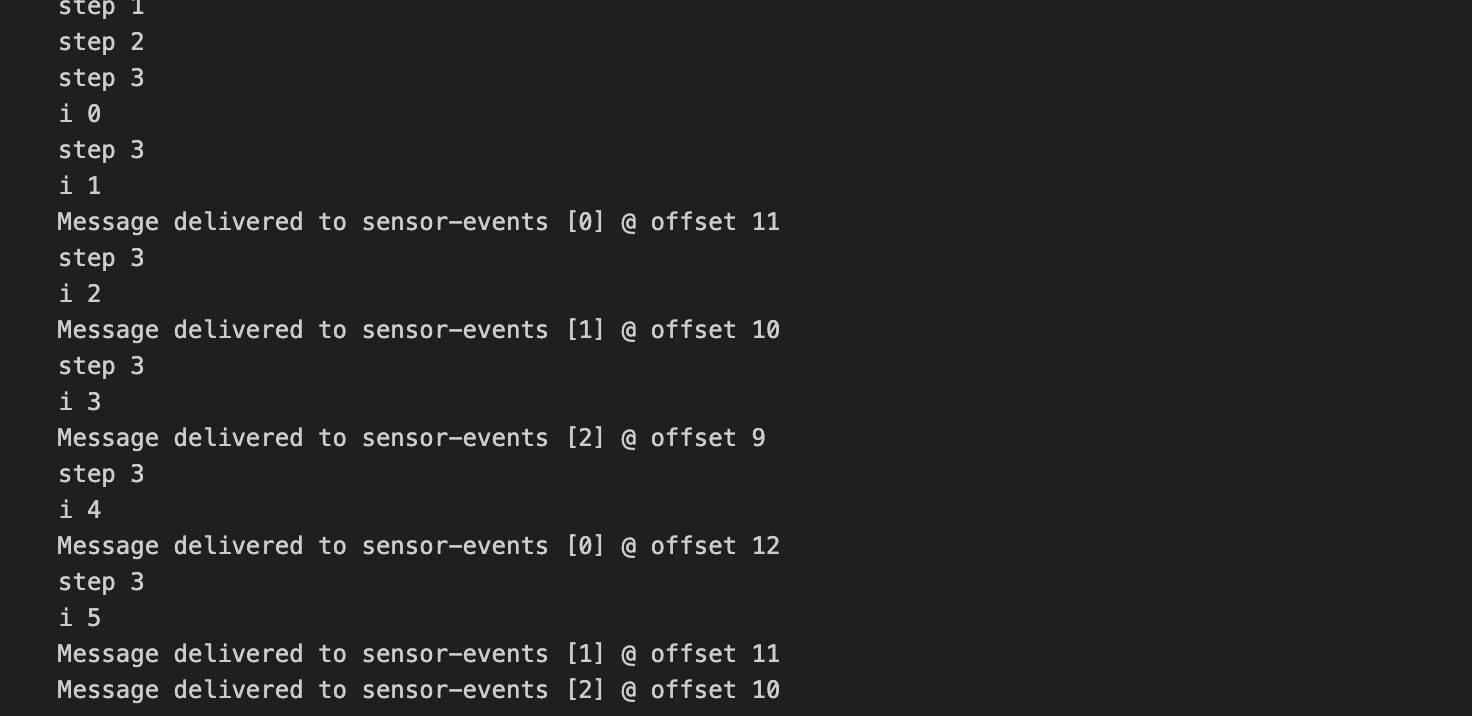

# 2. Store the Kafka Events in a Table-like Format

## Option A: Write to Parquet

In [8]:
import json
import pandas as pd
from confluent_kafka import Consumer

# Kafka consumer configuration for two brokers
conf = {
    'bootstrap.servers': 'localhost:19092,localhost:19093',  # <-- both brokers
    'group.id': 'my-consumer-group',
    'auto.offset.reset': 'earliest'
}

batch_size = 10  # number of messages per parquet file
file_count = 0
buffer = []  # initialize buffer

# Create the consumer and subscribe to your topic
consumer = Consumer(conf)
consumer.subscribe(['test-topic'])  # make sure this matches your topic

try:
    while True:
        msg = consumer.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            print(msg.error())
            continue

        # Decode message
        message_value = json.loads(msg.value().decode('utf-8'))

        print(
            "Partition", msg.partition(),
            "seq", msg.key().decode() if msg.key() else None,
            "Row", message_value,
            "Timestamp", message_value.get("ts")
        )

        # Append relevant fields to buffer
        buffer.append({
            'seq': message_value['seq'],
            'ts': message_value['ts'],
            'pattern': message_value.get('pattern'),
            'rate': message_value.get('rate'),
            'noise': message_value.get('noise'),
            'n_sensors': message_value.get('n_sensors'),
            'sensor_1': message_value['values']['sensor_1']
        })

        # Writing consumed data to a parquet for every 20 records (a batch) into a parquet
        # The name of the parquet is organized by the timestamp of the first row in a batch
        if len(buffer) >= batch_size:
            timestamp = buffer[0]["ts"]
            df = pd.DataFrame(buffer)
            file_count += 1
            filename = f'kafka_batch_{file_count}_{timestamp}.parquet'
            df.to_parquet(filename, engine='pyarrow', index=False)
            print(f"Wrote {len(buffer)} messages to {filename}")
            buffer = []  # clear buffer

finally:
    consumer.close()


Partition 0 seq 0 Row {'seq': 0, 'ts': 1767027348.2300634, 'pattern': 'random', 'rate': 1.0, 'noise': 0.1, 'n_sensors': 1, 'values': {'sensor_1': 0.4263906055780244}} Timestamp 1767027348.2300634
Partition 0 seq 3 Row {'seq': 3, 'ts': 1767027351.2324884, 'pattern': 'random', 'rate': 1.0, 'noise': 0.1, 'n_sensors': 1, 'values': {'sensor_1': 0.2475832738395316}} Timestamp 1767027351.2324884
Partition 0 seq 6 Row {'seq': 6, 'ts': 1767027354.235512, 'pattern': 'random', 'rate': 1.0, 'noise': 0.1, 'n_sensors': 1, 'values': {'sensor_1': 0.6632347870703984}} Timestamp 1767027354.235512
Partition 0 seq 9 Row {'seq': 9, 'ts': 1767027357.237998, 'pattern': 'random', 'rate': 1.0, 'noise': 0.1, 'n_sensors': 1, 'values': {'sensor_1': 0.10345655693920183}} Timestamp 1767027357.237998
Partition 0 seq 12 Row {'seq': 12, 'ts': 1767027360.2400966, 'pattern': 'random', 'rate': 1.0, 'noise': 0.1, 'n_sensors': 1, 'values': {'sensor_1': 0.6398314747672227}} Timestamp 1767027360.2400966
Partition 0 seq 15 Ro

KeyboardInterrupt: 

# 3. Partitioning and Broker Roles

The partition function is defined as `seq % num_partition`. `%` is the modulo operator which gives the remainder of the division between `seq` and `num_partitions`
For instance if the value of `seq` is 5 and `num_partitions` is 3, then `seq % num_partition` gives 2 in which case the row would be assigned to partition 2. This way each row can be assigned to a unique partition. The above architecture is a 2 broker environment (kafka1 and kafka2 being the broker names). Every partition has a leader and a follower broker.

The topic test-topic in kafka has 3 partitions each having leader and follower broker which can be seen as follows:



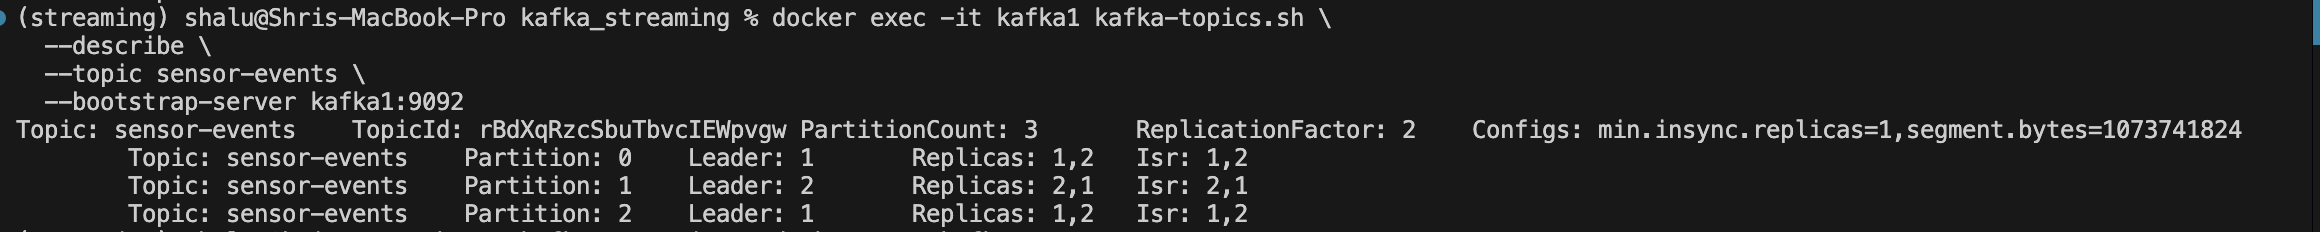

In the above image, one could observer that, the partition 0 has broker 1 as leader broker and broker 2 as follower broker. 
Partition 1 has broker 2 as leader broker and broker 1 as follower broker etc., So data belonging to parition 0 would have leader broker as broker 1 and follower broker as broker 2.


Partition distribution before stopping a broker

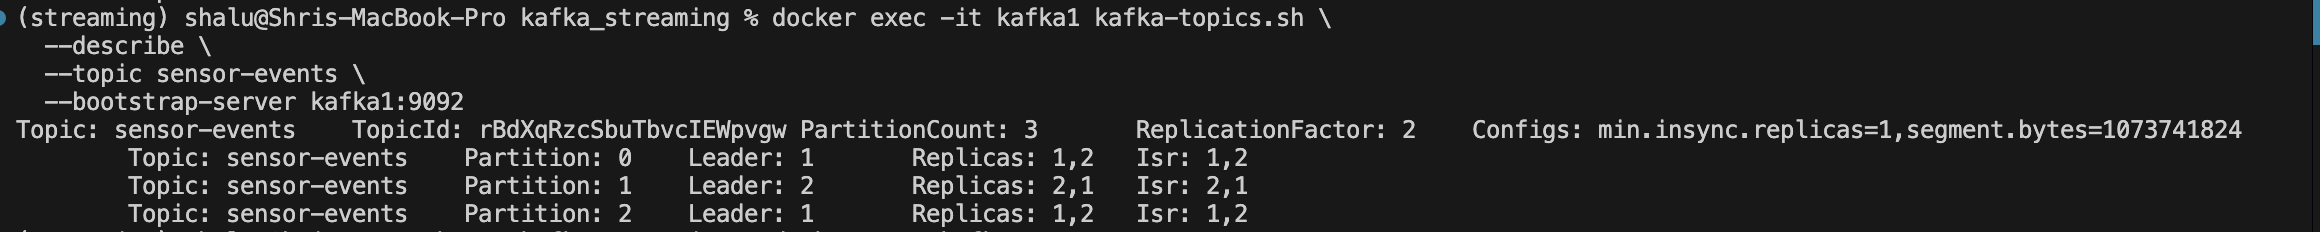

Partition distribution after stopping broker 1 caused by new leader election. Note that, since broker 1 is stopped, for every broker that had broker 1 as leader is assigned to broker 2 after stopping.

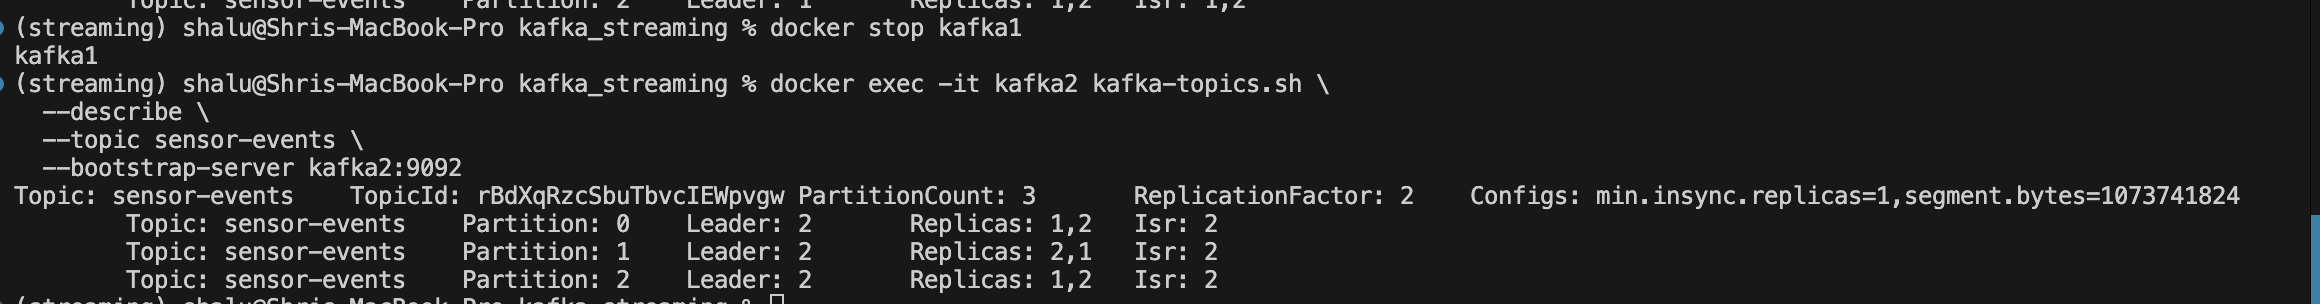

Even if one broker is stopped and producer is run, the producer continues running but sends the data to the new leader and follower brokers based on the new leader election. In the above case, when broker 1 is stopped, all data produced gets sent to broker 2.